## Spatially register the two MERFISH slices with rigid transformation

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import umap
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import get_cmap

import INSPIRE

### Load results

In [2]:
res_path = "Results/INSPIRE_registration_merfish"
adata = sc.read_h5ad(res_path + "/adata_inspire.h5ad")

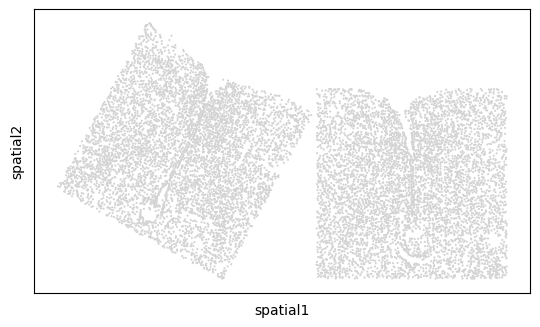

In [3]:
sc.pl.spatial(adata, spot_size=20)

### Find anchor cells (MNN cells across slices in the latent space)

In [4]:
adata_0 = adata[adata.obs["Bregma"]==-0.09, :]
adata_1 = adata[adata.obs["Bregma"]==-0.04, :]

loc0 = adata_0.obsm["spatial"]
loc1 = adata_1.obsm["spatial"]

latent_0 = adata_0.obsm['latent']
latent_1 = adata_1.obsm['latent']

In [5]:
mnn_mat = INSPIRE.utils.acquire_pairs(latent_0, latent_1, k=1, metric='euclidean')
idx_0 = []
idx_1 = []
for i in range(mnn_mat.shape[0]):
    if np.sum(mnn_mat[i, :]) > 0:
        nns = np.where(mnn_mat[i, :] == 1)[0]
        for j in list(nns):
            idx_0.append(i)
            idx_1.append(j)
loc0_pair = loc0[idx_0, :]
loc1_pair = loc1[idx_1, :]

### Register slice 1 onto slice 2

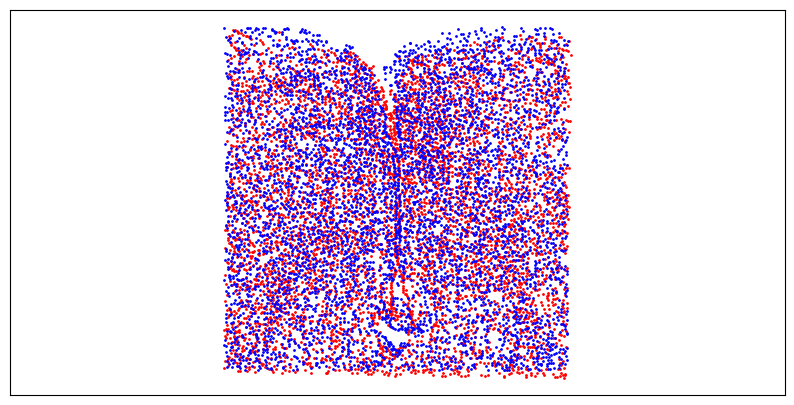

In [6]:
T,_,_ = INSPIRE.utils.best_fit_transform(loc0_pair, loc1_pair)
loc0_new = INSPIRE.utils.transform(loc0, T)

f = plt.figure(figsize=(10,5))
ax = f.add_subplot(1,1,1)
ax.axis('equal')
ax.scatter(loc0_new[:,0], -loc0_new[:,1], c="red", s=1)
ax.scatter(loc1[:,0], -loc1[:,1], c="blue", s=1)
ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
plt.show()

### Register slice 2 onto slice 1

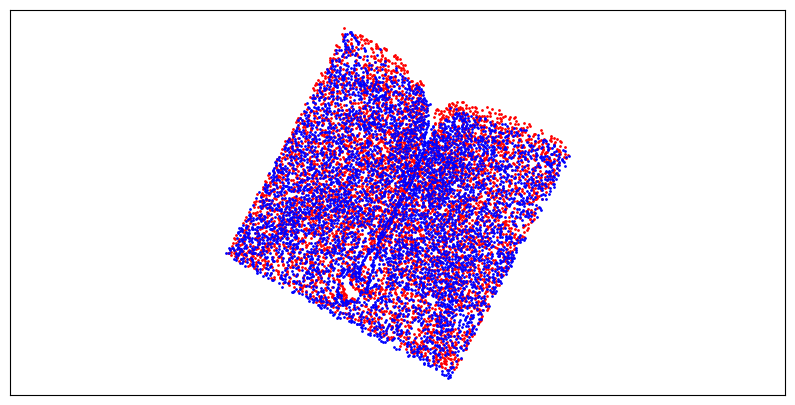

In [7]:
T,_,_ = INSPIRE.utils.best_fit_transform(loc1_pair, loc0_pair)
loc1_new = INSPIRE.utils.transform(loc1, T)

f = plt.figure(figsize=(10,5))
ax = f.add_subplot(1,1,1)
ax.axis('equal')
ax.scatter(loc1_new[:,0], -loc1_new[:,1], c="red", s=1)
ax.scatter(loc0[:,0], -loc0[:,1], c="blue", s=1)
ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
plt.show()

### Save result

In [8]:
adata_0.obsm["loc_aligned"] = loc0_new
adata_1.obsm["loc_aligned"] = loc1

In [9]:
res_path = "Results/INSPIRE_registration_merfish"
adata_0.write(res_path + "/adata_st_list_0_loc_aligned.h5ad")
adata_1.write(res_path + "/adata_st_list_1_loc_aligned.h5ad")